## Jiaxu He
## ANLY-590
## HW2

## 1. Autoencoder

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D
from keras.layers import Dropout, Activation, Flatten, LSTM
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import VGG16
import cv2
from keras.preprocessing import sequence

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28,1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28,1).astype('float32') / 255
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

4423680/4422102 [==============================] - 1s 0us/step


In [4]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.3730 - val_loss: 0.3363
Epoch 2/10
60000/60000 [==============================] - 80s 1ms/step - loss: 0.3255 - val_loss: 0.3189
Epoch 3/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.3151 - val_loss: 0.3159
Epoch 4/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.3094 - val_loss: 0.3097
Epoch 5/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.3054 - val_loss: 0.3092
Epoch 6/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.3030 - val_loss: 0.3054
Epoch 7/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.3016 - val_loss: 0.3003
Epoch 8/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.2996 - val_loss: 0.3030
Epoch 9/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.2994 - val_loss: 0.3030
Epoch

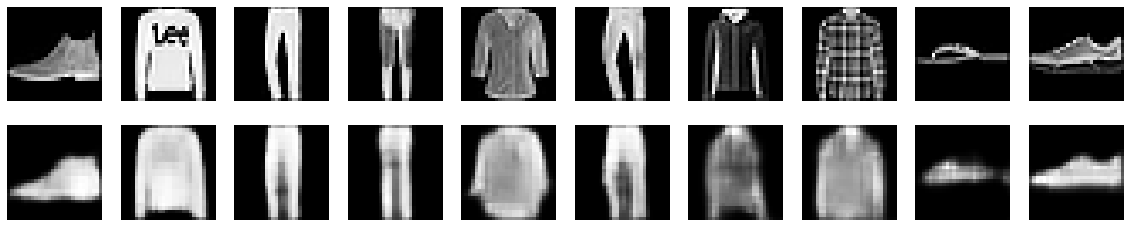

In [6]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 2. Image Classifcation


### 2.1 Deep CNN

In [9]:
# =============================
#  Setting up the Architecture
# ============================
# Declaring sequential model
model = Sequential()
# CNN input layer: input_shape: (depth,width,height)
# CNN convolution: number of filters, height and width of kernel
model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid',
                 input_shape=(28,28,1)))
# Notice here the the first entry output is none
print(model.output_shape)

# Next we add the remaining layers
model.add(Conv2D(filters = 32,kernel_size=(3, 3), 
                 activation='relu', strides=(1, 1), 
                 padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Setting up the fully connected lauer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
print(model.summary())

(None, 26, 26, 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                294976    
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0 

#### The architectural choices that I've made are kernel size of (3, 3), strides of (1, 1), padding of "valid", and the network depth of 32 for the first 2D convolutional layer, then I added another convolutional layer with kernel size of (3, 3), strides of (1, 1), padding of "valid", and the network depth of 32. Next, added maxpooling layer and dropout with rate of 0.25. 

In [15]:
# =========================================
# Multigpu support Function Make-Parallel
# ========================================
# MultiGPU hack: 
# https://github.com/rossumai/keras-multi-gpu/tree/master/keras_tf_multigpu

# =====================
#  Compiling the model
# =====================
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# ===================
# Fitting the model
# ===================
model.fit(x_train, y_train,
          epochs=10,
          batch_size=128)


Epoch 1/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.2194 - acc: 0.9194
Epoch 2/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.2083 - acc: 0.9227
Epoch 3/10
60000/60000 [==============================] - 101s 2ms/step - loss: 0.2039 - acc: 0.9251
Epoch 4/10
60000/60000 [==============================] - 100s 2ms/step - loss: 0.1975 - acc: 0.9258
Epoch 5/10
60000/60000 [==============================] - 101s 2ms/step - loss: 0.1950 - acc: 0.9275
Epoch 6/10
60000/60000 [==============================] - 101s 2ms/step - loss: 0.1916 - acc: 0.9273
Epoch 7/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.1861 - acc: 0.9289
Epoch 8/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.1789 - acc: 0.9322
Epoch 9/10
60000/60000 [==============================] - 101s 2ms/step - loss: 0.1781 - acc: 0.9324
Epoch 10/10
60000/60000 [==============================] - 101s 2ms/step - loss: 0.1764 - a

In [16]:
# =====================
#  Evaluating the model
# =====================
score = model.evaluate(x_test, y_test, verbose=1)
print(score)

10000/10000 [==============================] - 5s 520us/step
[0.2269569096058607, 0.9252]


#### As the results showed above, the model has good performances on training set and test set. It has accuracy of 0.9331 on the training set and accuracy of 0.9252 on the test set.

### 2.2 Transfer Learning

In [19]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = [cv2.cvtColor(cv2.resize(i, (32, 32)), cv2.COLOR_GRAY2BGR) for i in x_train]
x_train = np.concatenate([arr[np.newaxis] for arr in x_train]).astype('float32')

x_test = [cv2.cvtColor(cv2.resize(i, (32, 32)), cv2.COLOR_GRAY2BGR) for i in x_test]
x_test = np.concatenate([arr[np.newaxis] for arr in x_test]).astype('float32')

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(32,32,3))

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(10, activation="sigmoid"))
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
_________________________________________________________________


In [21]:

conv_base.trainable = False
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs=5,
          batch_size=256)

Epoch 1/5
60000/60000 [==============================] - 660s 11ms/step - loss: 0.8278 - acc: 0.7224
Epoch 2/5
60000/60000 [==============================] - 659s 11ms/step - loss: 0.6046 - acc: 0.7959
Epoch 3/5
60000/60000 [==============================] - 659s 11ms/step - loss: 0.4845 - acc: 0.8259
Epoch 4/5
60000/60000 [==============================] - 659s 11ms/step - loss: 0.4257 - acc: 0.8419
Epoch 5/5
60000/60000 [==============================] - 658s 11ms/step - loss: 0.3937 - acc: 0.8515


In [23]:
score = model.evaluate(x_test, y_test, verbose=1)
print(score)

10000/10000 [==============================] - 112s 11ms/step
[0.44513814458847045, 0.8469]


#### As the results showed above, the model has good performances on training set and test set. It has accuracy of 0.8515 on the training set and accuracy of 0.8469 on the test set.



## 3. Text Classification

### 3.1 RNN

In [33]:
import requests
from sklearn.model_selection import train_test_split

benign = requests.get("https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt").text.split("\n")
malicious = requests.get("https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt").text.split("\n")
benign = [x for x in benign if x[0] != "#"]    

total = benign + malicious
labels = [0]*len(benign)+[1]*len(malicious)
chars = sorted(list(set(''.join(total))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
maxlen = max(len(i) for i in total)

total chars: 67


In [0]:
X = np.zeros((len(total), maxlen, len(chars)), dtype=np.uint8)
for i, seq in enumerate(total):
    for t, char in enumerate(seq):
        X[i, t, char_indices[char]] = 1

x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [35]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 53849 samples, validate on 13463 samples
Epoch 1/10
53849/53849 [==============================] - 108s 2ms/step - loss: 0.1023 - acc: 0.9802 - val_loss: 0.0949 - val_acc: 0.9808
Epoch 2/10
53849/53849 [==============================] - 107s 2ms/step - loss: 0.0967 - acc: 0.9807 - val_loss: 0.0950 - val_acc: 0.9808
Epoch 3/10
53849/53849 [==============================] - 108s 2ms/step - loss: 0.0965 - acc: 0.9807 - val_loss: 0.0948 - val_acc: 0.9808
Epoch 4/10
53849/53849 [==============================] - 107s 2ms/step - loss: 0.0964 - acc: 0.9807 - val_loss: 0.0948 - val_acc: 0.9808
Epoch 5/10
53849/53849 [==============================] - 107s 2ms/step - loss: 0.0963 - acc: 0.9807 - val_loss: 0.0954 - val_acc: 0.9808
Epoch 6/10
53849/53849 [==============================] - 107s 2ms/step - loss: 0.0961 - acc: 0.9807 - val_loss: 0.0975 - val_acc: 0.9808
Epoch 7/10
53849/53849 [==============================] - 105s 2ms/step - loss: 0.0962 - acc: 0.9807 - val_loss: 0.0949 - 

#### As the results showed above, the LSTM type of RNN has really good performance on training set and test set, with training set, it has accuracy of 0.9807. With test set, it has accuracy of 0.9808, which is really good!

### 3.2 CNN

In [36]:
model2 = Sequential()
model2.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu', input_shape=(maxlen, len(chars))))
model2.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu', input_shape=(maxlen, len(chars))))
model2.add(MaxPooling1D(pool_size=4))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model2.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 64)

Epoch 1/10
53849/53849 [==============================] - 21s 385us/step - loss: 0.0562 - acc: 0.9813
Epoch 2/10
53849/53849 [==============================] - 21s 382us/step - loss: 0.0287 - acc: 0.9874
Epoch 3/10
53849/53849 [==============================] - 20s 374us/step - loss: 0.0247 - acc: 0.9887
Epoch 4/10
53849/53849 [==============================] - 20s 371us/step - loss: 0.0249 - acc: 0.9897
Epoch 5/10
53849/53849 [==============================] - 20s 364us/step - loss: 0.0280 - acc: 0.9898
Epoch 6/10
53849/53849 [==============================] - 19s 361us/step - loss: 0.0368 - acc: 0.9888
Epoch 7/10
53849/53849 [==============================] - 19s 362us/step - loss: 0.0519 - acc: 0.9878
Epoch 8/10
53849/53849 [==============================] - 19s 361us/step - loss: 0.0795 - acc: 0.9859
Epoch 9/10
53849/53849 [==============================] - 20s 365us/step - loss: 0.1336 - acc: 0.9844
Epoch 10/10
53849/53849 [==============================] - 19s 352us/step - loss: 

In [37]:
score = model2.evaluate(x_test, y_test, verbose=1)
print(score)

13463/13463 [==============================] - 2s 161us/step
[0.3088813500774362, 0.980836366337369]


#### As the results showed above, the model has good performances on training set and test set. It has accuracy of 0.9813 on the training set and accuracy of 0.9908 on the test set. Which means the model is very good!

### 3.3

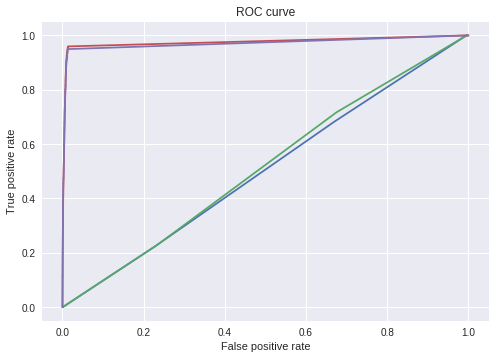

In [38]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plt.figure(1)
predictedrnntrain = model.predict(x_train)
fpr_train_r, tpr_train_r, thresholds_train_r = roc_curve(y_train, predictedrnntrain)
auc_train_r = auc(fpr_train_r, tpr_train_r)


predictedrnntest = model.predict(x_test)
fpr_test_r, tpr_test_r, thresholds_test_r  = roc_curve(y_test, predictedrnntest)
auc_test_r = auc(fpr_test_r, tpr_test_r)


predictedcnntrain = model2.predict(x_train)
fpr_train_c, tpr_train_c, thresholds_train_c = roc_curve(y_train, predictedcnntrain)
auc_train_c = auc(fpr_train_c, tpr_train_c)


predictedcnntest = model2.predict(x_test)
fpr_test_c, tpr_test_c, thresholds_test_c = roc_curve(y_test, predictedcnntest)
auc_test_c = auc(fpr_test_c, tpr_test_c)

plt.plot(fpr_train_r, tpr_train_r, label="RNN_training %0.3f" % auc_train_r)
plt.plot(fpr_test_r, tpr_test_r, label="RNN_test %0.3f" % auc_test_r)
plt.plot(fpr_train_c, tpr_train_c, label= "CNN_training %0.3f" % auc_train_c)
plt.plot(fpr_test_c, tpr_test_c, label= "CNN_test %0.3f" % auc_test_c)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#### From the ROC curve, it can tell that CNN is better than RNN. However, both models performed very well in the results showed above, where CNN has around 0.98 accuracy on both training and test sets, and RNN has around 0.98 accuracy on training and test sets. However, both models performed very well, it hard to tell which one is really better in this situation. Maybe with a better balanced data, we can tell which one fits more better.